# Introduction

The dataset that was used is located at https://archive.ics.uci.edu/dataset/45/heart+disease

The aim is to predict whether or not a patient has a heart disease.

# Base dataset exploration

In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features
y = heart_disease.data.targets

In [2]:
heart_disease.variables

,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,years,no
1,sex,Feature,Categorical,Sex,None,None,no
2,cp,Feature,Categorical,None,None,None,no
3,trestbps,Feature,Integer,None,resting blood pressure (on admission to the ho...,mm Hg,no
4,chol,Feature,Integer,None,serum cholestoral,mg/dl,no
5,fbs,Feature,Categorical,None,fasting blood sugar > 120 mg/dl,None,no
6,restecg,Feature,Categorical,None,None,None,no
7,thalach,Feature,Integer,None,maximum heart rate achieved,None,no
8,exang,Feature,Categorical,None,exercise induced angina,None,no
9,oldpeak,Feature,Integer,None,ST depression induced by exercise relative to ...,None,no


In [3]:
from pprint import pprint

pprint(heart_disease.metadata)

{'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long '
             'Beach',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'This database contains 76 attributes, but all '
                                'published experiments refer to using a subset '
                                'of 14 of them.  In particular, the Cleveland '
                                'database is the only one that has been used '
                                'by ML researchers to date.  The "goal" field '
                                'refers to the presence of heart disease in '
                                'the patient.  It is integer valued from 0 (no '
                  

In [4]:
categorical_columns = heart_disease.variables[
    heart_disease.variables["type"] == "Categorical"
]["name"].unique().tolist()

numerical_columns = heart_disease.variables[
    heart_disease.variables["type"] == "Integer"
]["name"].unique().tolist()
numerical_columns = list(filter(
    lambda col: col != "num", numerical_columns
))

## Distribution and description

In [5]:
X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


There seem to be a few different scales. Standardization will probably be called for.

In [6]:
y.describe()

,num
count,303.000000
mean,0.937294
std,1.228536
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,4.000000


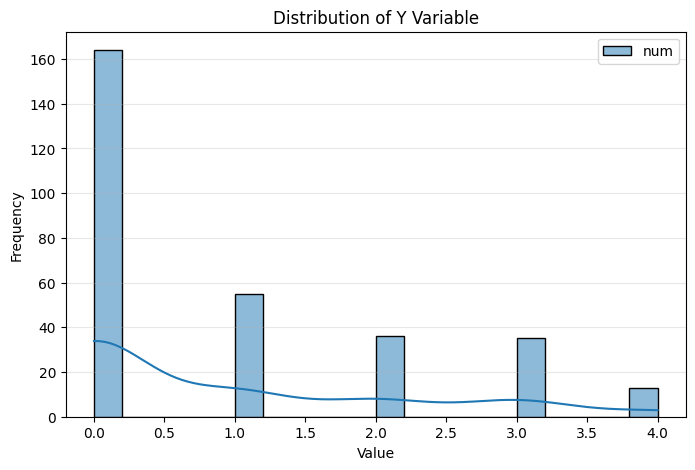

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=20, color='skyblue')
plt.title('Distribution of Y Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

There is very clear imbalance here in the sense that there are way more `0` than anything else (though binary-wise, it is almost balanced).

Since moving from multi-class to binary classification is fairly straightforward, we'll work on multi-class first.

## Missing values

According to the `heart_disease.variables`, it would appear that only `ca` and `thal` have missing values. Let's see the proportion of missing values.

In [8]:
X.isna().mean()

age         0.000000
sex         0.000000
cp          0.000000
trestbps    0.000000
chol        0.000000
fbs         0.000000
restecg     0.000000
thalach     0.000000
exang       0.000000
oldpeak     0.000000
slope       0.000000
ca          0.013201
thal        0.006601
dtype: float64

1.3% at worst. It is safe to assume we can afford to impute those values, or maybe tolerate null values, though keeping a mask for correlation analysis is relevant.

In [9]:
X["ca"].value_counts()

ca
0.0    176
1.0     65
2.0     38
3.0     20
Name: count, dtype: int64

In [10]:
X["thal"].value_counts()

thal
3.0    166
7.0    117
6.0     18
Name: count, dtype: int64

Given the low number of possible values for each feature, one possibility would be to make those features categorical and adding a category for `missing`. However, the `ca` feature is numerical and the notion of number comparison actually makes sense, so it would be better to keep it as numerical (unlike `thal` which is categorical).

Since there are so few missing values, I will go for a simple approach of mode imputation for now, while keeping other approaches (KNN for instance) in mind if I notice a large correlation between test errors and missing values.

## Outlier detection

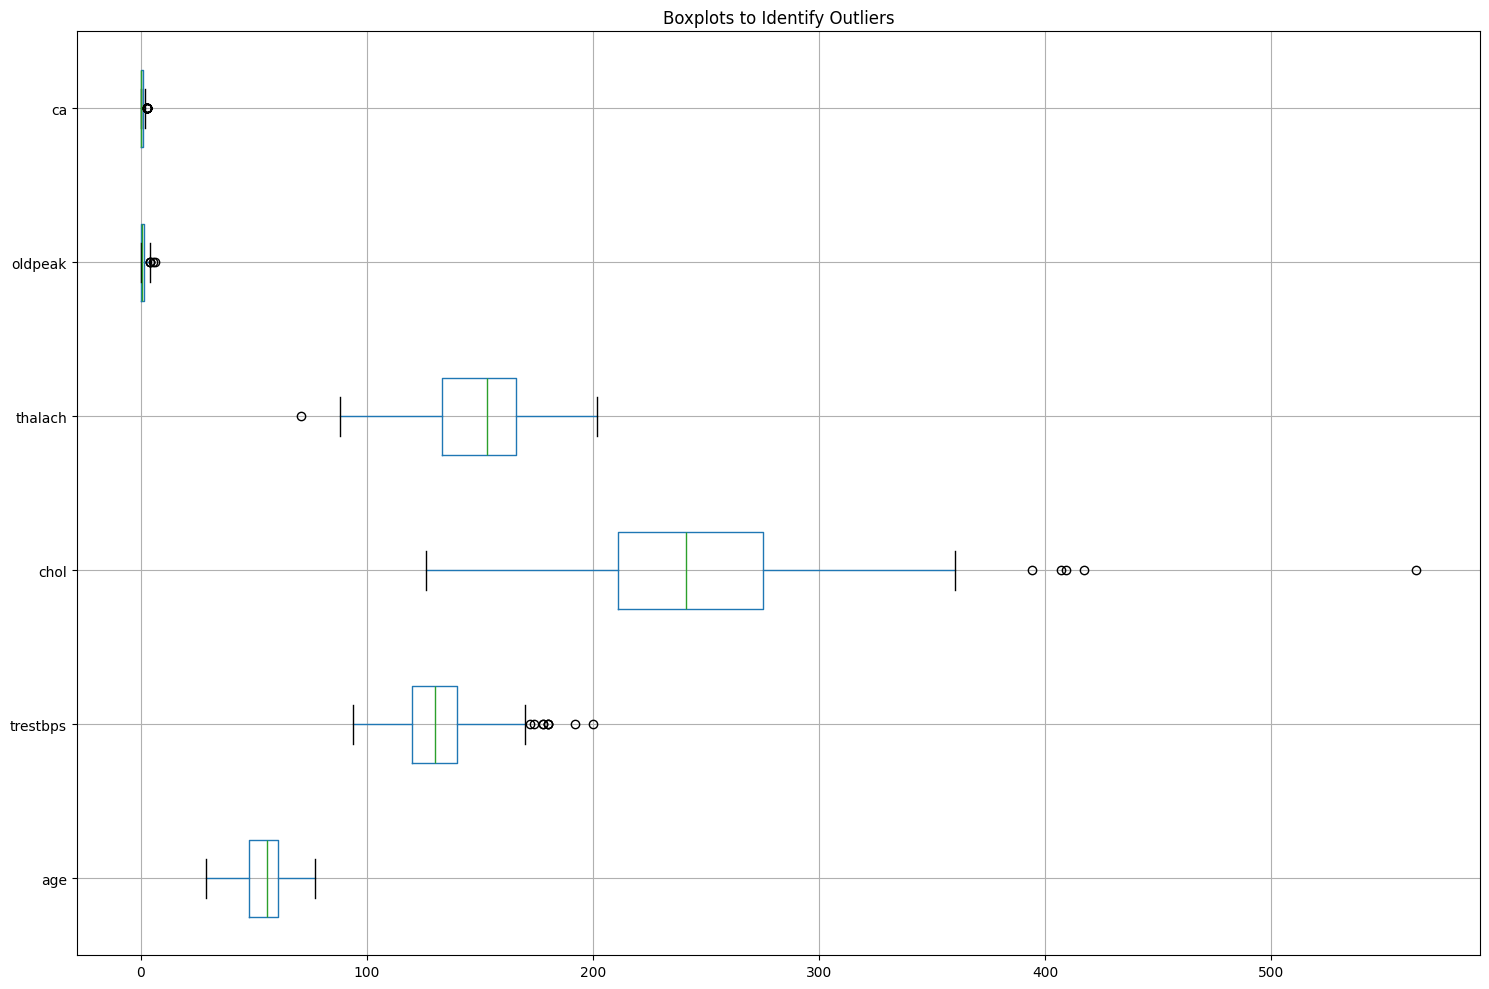

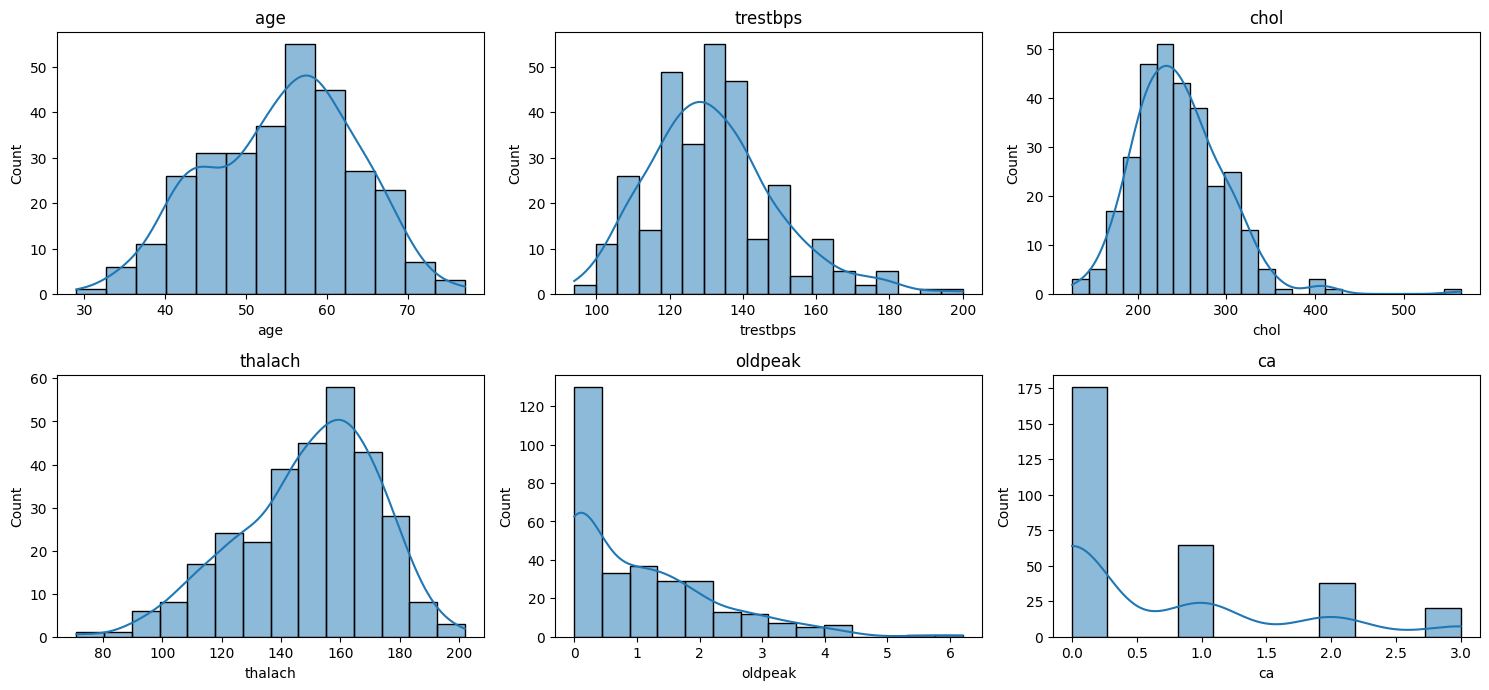

In [11]:
plt.figure(figsize=(15, 10))
X[numerical_columns].boxplot(vert=False)
plt.title("Boxplots to Identify Outliers")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns)//3 + 1, 3, i+1)
    sns.histplot(X[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

There are some outliers but not enough to be too big a problem.

## Correlations

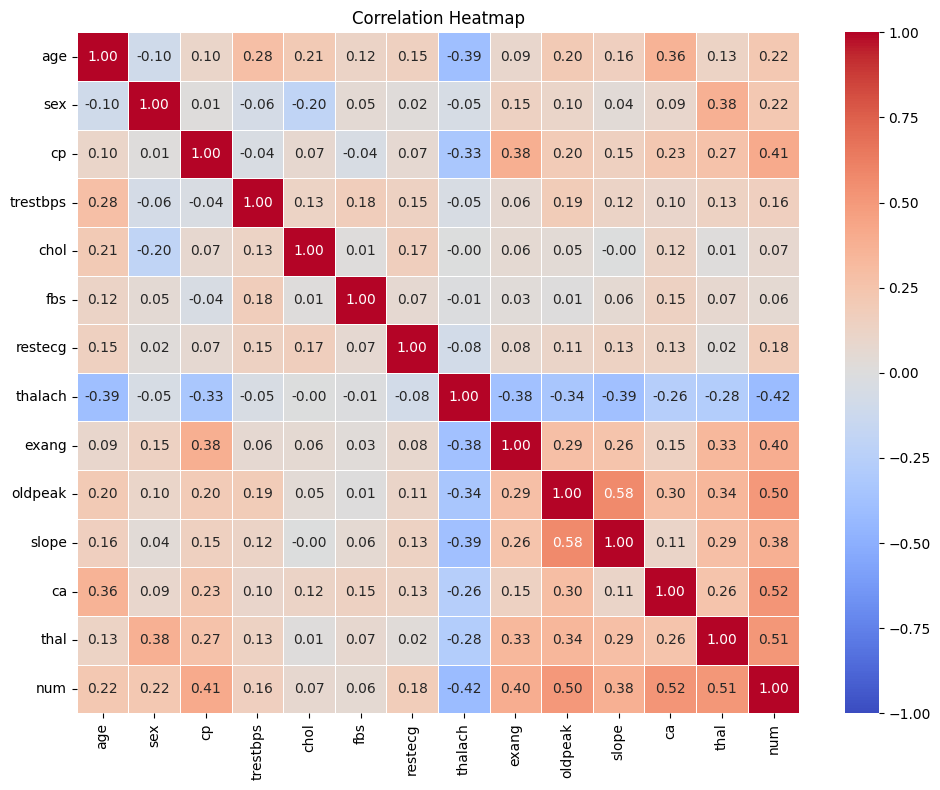

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = pd.concat([X, y], axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Many features are decently correlated with the target. It would be interesting to experiment with less features after getting our baseline to see if we can lighten the dataset.

# Dataset creation

In [13]:
from sklearn.model_selection import train_test_split

seed = 0
X_train, X_test, y_train, y_test = train_test_split(X, y["num"], train_size=0.6, random_state=seed)
# Validation sets will not be used since grid search uses cross validation and data is sparse
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=seed)

# Feature engineering

Since there is no medical expert with me at the moment, I will not explore the various correlations to see what features would be relevant to create. I will simply make the data model-ready.

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numerical_pipeline = Pipeline([
    # Note that for now only CA is targeted, there should be an alert in prod for other missing features
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),
        ('num', numerical_pipeline, numerical_columns)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train = pipeline.fit_transform(X_train)
# X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# Baseline models (multiclass)

We will start with a very simple baseline model like logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'max_iter': [2000]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.5, 0.8],
        'solver': ['saga'],
        'max_iter': [2000]
    }
]

def binary_recall(y_true, y_pred):
    y_true_binary = (y_true > 0).astype(int)
    y_pred_binary = (y_pred > 0).astype(int)
    return recall_score(y_true_binary, y_pred_binary)

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=make_scorer(binary_recall),
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Get best model and parameters
lr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

y_test_pred = lr_model.predict(X_test)
y_train_pred = lr_model.predict(X_train)

res = {}

def basic_metrics(true, preds, ds_type):
    results = {}
    # Original multi-class metrics
    print(f"=== MULTI-CLASS METRICS {ds_type} ===")
    accuracy = accuracy_score(true, preds)
    results[f"{ds_type}_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    
    # print("\nClassification Report:")
    # print(classification_report(true, preds))
    
    print(f"\nConfusion Matrix {ds_type}:")
    print(confusion_matrix(true, preds))
    
    # Binarize the data (0 vs >0)
    print(f"\n=== BINARY METRICS (0 vs >0) {ds_type} ===")
    true_binary = (true > 0).astype(int)
    preds_binary = (preds > 0).astype(int)
    
    binary_accuracy = accuracy_score(true_binary, preds_binary)
    results[f"{ds_type}_binary_accuracy"] = binary_accuracy
    print(f"Binary Accuracy: {binary_accuracy:.4f}")

    binary_recall = recall_score(true_binary, preds_binary)
    results[f"{ds_type}_binary_recall"] = binary_recall
    print(f"Binary Recall: {binary_recall:.4f}")
    
    # print("\nBinary Classification Report:")
    # print(classification_report(true_binary, preds_binary))
    
    print(f"\nBinary Confusion Matrix: {ds_type}")
    print(confusion_matrix(true_binary, preds_binary))
    
    return results

res.update(basic_metrics(y_test, y_test_pred, "test_lr_mc"))
res.update(basic_metrics(y_train, y_train_pred, "train_lr_mc"))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/manu/Library/Caches/pypoetry/virtualenvs/caresentinel-paQ0MA83-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manu/Library/Caches/pypoetry/virtualenvs/caresentinel-paQ0MA83-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manu/Library/Caches/pypoetry/virtualenvs/caresentinel-paQ0MA83-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manu/Library/Caches/pypoetry/virtualenvs/caresentinel-paQ0MA83-py3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/manu/Library/Caches/pypoetry/

Best Parameters: {'C': 100, 'l1_ratio': 0.5, 'max_iter': 2000, 'penalty': 'elasticnet', 'solver': 'saga'}
=== MULTI-CLASS METRICS test_lr_mc ===
Accuracy: 0.4918

Confusion Matrix test_lr_mc:
[[50  5  3  1  1]
 [11  4  2  7  3]
 [ 2  7  3  1  3]
 [ 1  3  4  3  3]
 [ 1  2  1  1  0]]

=== BINARY METRICS (0 vs >0) test_lr_mc ===
Binary Accuracy: 0.7951
Binary Recall: 0.7581

Binary Confusion Matrix: test_lr_mc
[[50 10]
 [15 47]]
=== MULTI-CLASS METRICS train_lr_mc ===
Accuracy: 0.8011

Confusion Matrix train_lr_mc:
[[102   2   0   0   0]
 [  9  11   3   4   1]
 [  2   3  13   1   1]
 [  0   6   2  13   0]
 [  0   1   0   1   6]]

=== BINARY METRICS (0 vs >0) train_lr_mc ===
Binary Accuracy: 0.9282
Binary Recall: 0.8571

Binary Confusion Matrix: train_lr_mc
[[102   2]
 [ 11  66]]


The baseline model clearly overfits despite the regularization.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

y_test_pred = rfc.predict(X_test)
y_train_pred = rfc.predict(X_train)

res.update(basic_metrics(y_test, y_test_pred, "test_rf_mc"))
res.update(basic_metrics(y_train, y_train_pred, "train_rf_mc"))

=== MULTI-CLASS METRICS test_rf_mc ===
Accuracy: 0.5246

Confusion Matrix test_rf_mc:
[[57  1  2  0  0]
 [18  2  3  4  0]
 [ 6  2  3  5  0]
 [ 6  3  2  2  1]
 [ 0  2  0  3  0]]

=== BINARY METRICS (0 vs >0) test_rf_mc ===
Binary Accuracy: 0.7295
Binary Recall: 0.5161

Binary Confusion Matrix: test_rf_mc
[[57  3]
 [30 32]]
=== MULTI-CLASS METRICS train_rf_mc ===
Accuracy: 1.0000

Confusion Matrix train_rf_mc:
[[104   0   0   0   0]
 [  0  28   0   0   0]
 [  0   0  20   0   0]
 [  0   0   0  21   0]
 [  0   0   0   0   8]]

=== BINARY METRICS (0 vs >0) train_rf_mc ===
Binary Accuracy: 1.0000
Binary Recall: 1.0000

Binary Confusion Matrix: train_rf_mc
[[104   0]
 [  0  77]]


Unsurprisingly, there is massive overfitting here.


When comparing with the Logistic Regression, one can observe that Random Forest tends to classify samples as the majority sample, `0`, while the errors for the Logistic Regression are more spread out.

In both cases, the model struggles to classify level 4 severity correctly.

In [17]:
reshaped_data = []
results = res

MODELS = {"lr_mc": "Logistic regression" , "rf_mc": "Random forest"}

for key, value in results.items():
    dataset = key.split('_')[0]
    for model_ in MODELS:
        if model_ in key:
            model = MODELS[model_]
            break
    metric_type = key.split(model_)[-1][1:]
    
    reshaped_data.append({
        'dataset': dataset,
        'model': model,
        'accuracy': value if metric_type == 'accuracy' else None,
        'binary_accuracy': value if metric_type == 'binary_accuracy' else None,
        'binary_recall': value if metric_type == 'binary_recall' else None
    })

df = pd.DataFrame(reshaped_data).groupby(['dataset', 'model']).first().reset_index()
df = df.round(3)

df

,dataset,model,accuracy,binary_accuracy,binary_recall
0,test,Logistic regression,0.492,0.795,0.758
1,test,Random forest,0.525,0.730,0.516
2,train,Logistic regression,0.801,0.928,0.857
3,train,Random forest,1.000,1.000,1.000


The logistic regression here is better than the random forest. It is not that suprising, given that there was a grid search for the logistic regression, and also given the simplicity of the data (low sample count and not that many features), the simpler model has decent chances to be better.

# Binary classification

## Important note
The best probability threshold to consider that a patient is at risk is probably not `0.5`. This would have to be discussed with various stakeholders.

## Why binary classification
We noted that the models were not performing too well on multi class classification. While there is room for improvement, it also seems that it makes sense to have a binary classification model work first, and a second model could potentially come complete it if necessary (one model to discriminate heart disease and another to assess the severity).<br>
It seems more important to be able to detect heart disease as a first step so that decisions can be made quicker.

In [18]:
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

param_grid = [
    {
        'penalty': ['l1', 'l2'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'max_iter': [2000]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0.2, 0.5, 0.8],
        'solver': ['saga'],
        'max_iter': [2000]
    }
]

grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train_binary)

# Get best model and parameters
lr_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

y_test_pred = lr_model.predict(X_test)
y_train_pred = lr_model.predict(X_train)

def binary_metrics(true, preds, ds_type):
    results = {}
    
    # Calculate accuracy
    print(f"=== BINARY METRICS {ds_type} ===")
    accuracy = accuracy_score(true, preds)
    results[f"{ds_type}_accuracy"] = accuracy
    print(f"Accuracy: {accuracy:.4f}")
    
    # Calculate precision, recall, and F1
    precision = precision_score(true, preds)
    recall = recall_score(true, preds)
    f1 = f1_score(true, preds)
    
    results[f"{ds_type}_precision"] = precision
    results[f"{ds_type}_recall"] = recall
    results[f"{ds_type}_f1"] = f1
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Confusion matrix
    print(f"\nConfusion Matrix {ds_type}:")
    cm = confusion_matrix(true, preds)
    print(cm)
    
    # Calculate specificity (true negative rate)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    results[f"{ds_type}_specificity"] = specificity
    print(f"Specificity: {specificity:.4f}")
    
    return results

binary_res = {}
binary_res.update(binary_metrics(y_test_binary, y_test_pred, "test_lr_mc"))
binary_res.update(binary_metrics(y_train_binary, y_train_pred, "train_lr_mc"))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'C': 1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
=== BINARY METRICS test_lr_mc ===
Accuracy: 0.8197
Precision: 0.8448
Recall: 0.7903
F1 Score: 0.8167

Confusion Matrix test_lr_mc:
[[51  9]
 [13 49]]
Specificity: 0.8500
=== BINARY METRICS train_lr_mc ===
Accuracy: 0.8895
Precision: 0.9130
Recall: 0.8182
F1 Score: 0.8630

Confusion Matrix train_lr_mc:
[[98  6]
 [14 63]]
Specificity: 0.9423


In [20]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'Specificity']
datasets = ['Test', 'Train']

data = []
for metric in metrics:
    row = {'Metric': metric}
    for dataset in datasets:
        key_prefix = f"{dataset.lower()}_lr_mc"
        metric_key = f"{key_prefix}_{metric.lower()}"
        if metric == 'Specificity':
            row[dataset] = float(binary_res[metric_key])
        else:
            row[dataset] = binary_res[metric_key]
    data.append(row)

pd.DataFrame(data)

,Metric,Test,Train
0,Accuracy,0.819672,0.889503
1,Precision,0.844828,0.913043
2,Recall,0.790323,0.818182
3,F1,0.816667,0.863014
4,Specificity,0.850000,0.942308


We get very good results here, comparable to what has been achieved on the website.

It would be interesting to run larger or more complex models on more data, and probably also keep some of the features that were dropped from this dataset (including the target features for each vessel).

# Explainability

Top 10 Most Important Features:
    Feature  Coefficient  Abs_Coefficient
0  thal_7.0     1.600716         1.600716
1        ca     1.173680         1.173680
2   slope_2     1.082766         1.082766
3   exang_1     0.829687         0.829687
4      cp_3    -0.783477         0.783477
5      cp_4     0.754553         0.754553
6     sex_1     0.664989         0.664989
7   thalach    -0.577222         0.577222
8   oldpeak     0.430857         0.430857
9      chol     0.278401         0.278401


/var/folders/s9/l9tx12554635m7lj0kynxsm40000gn/T/ipykernel_12217/768124936.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette=colors)


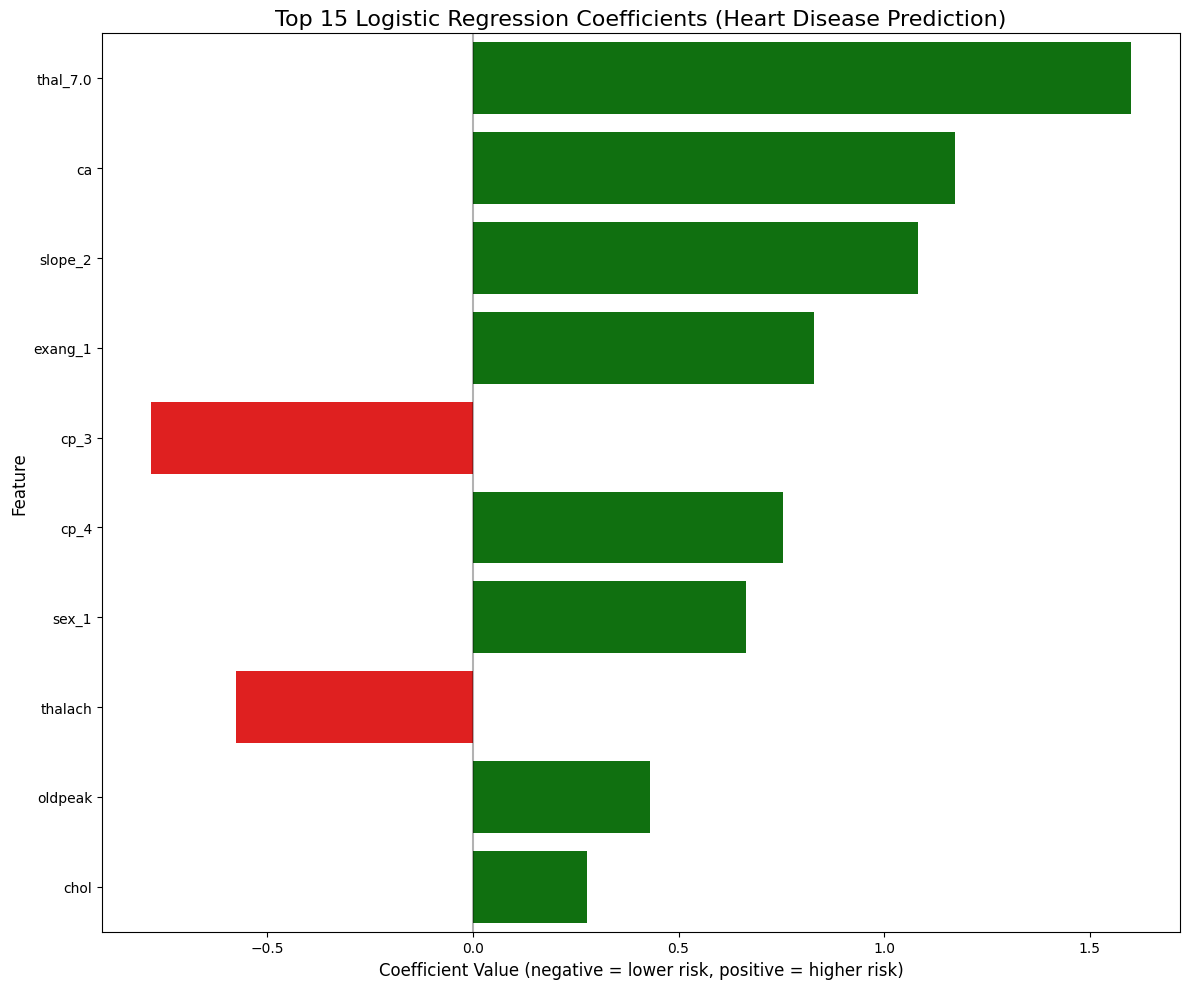

In [21]:
categorical_encoded = []
encoder = preprocessor.named_transformers_['cat']
cat_features = encoder.get_feature_names_out(categorical_columns)
categorical_encoded = list(cat_features)

feature_names = categorical_encoded + numerical_columns
coefficients = lr_model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

print("Top 10 Most Important Features:")
print(coef_df.head(10))

plt.figure(figsize=(12, 10))
colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient'].head(10)]
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10), palette=colors)
plt.title('Top 15 Logistic Regression Coefficients (Heart Disease Prediction)', fontsize=16)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Coefficient Value (negative = lower risk, positive = higher risk)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show();

### Note
This analysis could be improved given that some features were dropped (with the `first` during categorical transformations)

# Model dumping

In [22]:
import joblib

complete_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lr_model)
])
joblib.dump(complete_pipeline, "./data/pipelines/complete_binary_pipeline.jdp")

['./data/pipelines/complete_binary_pipeline.jdp']